In [ ]:
# Cell 1 - Importations avec insights de l'analyse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Chargement des données
df = pd.read_csv('stock_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Ticker', 'Date'])

print("🎯 BASÉ SUR L'ANALYSE EXPLORATOIRE:")
print(f"- 5 tickers, 200 jours chacun")
print(f"- Période: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"- Fortes corrélations prix → utiliser returns/volumes pour anomalies")

🎯 BASÉ SUR L'ANALYSE EXPLORATOIRE:
- 5 tickers, 200 jours chacun
- Période: 2023-04-06 to 2024-01-23
- Fortes corrélations prix → utiliser returns/volumes pour anomalies


In [2]:
# Cell 2 - Feature Engineering OPTIMISÉ (basé sur vos données)
print("🔧 CRÉATION DES FEATURES POUR ANOMALY DETECTION...")

features_list = []

for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].copy()
    
    # 1. RETURNS (très important pour anomalies)
    ticker_data['daily_return'] = ticker_data['Close'].pct_change()
    ticker_data['return_abs'] = np.abs(ticker_data['daily_return'])
    
    # 2. VOLATILITÉ (détection mouvements extrêmes)
    ticker_data['volatility_5d'] = ticker_data['daily_return'].rolling(5).std()
    ticker_data['volatility_10d'] = ticker_data['daily_return'].rolling(10).std()
    
    # 3. MOMENTUM (changements de tendance)
    ticker_data['momentum_5d'] = ticker_data['Close'].pct_change(5)
    ticker_data['momentum_10d'] = ticker_data['Close'].pct_change(10)
    
    # 4. VOLUME ABNORMAL (spikes de volume)
    ticker_data['volume_ma_10'] = ticker_data['Volume'].rolling(10).mean()
    ticker_data['volume_zscore'] = (ticker_data['Volume'] - ticker_data['Volume'].rolling(20).mean()) / ticker_data['Volume'].rolling(20).std()
    
    # 5. PRIX EXTREME RATIOS
    ticker_data['high_low_ratio'] = ticker_data['High'] / ticker_data['Low']
    ticker_data['open_close_gap'] = (ticker_data['Close'] - ticker_data['Open']) / ticker_data['Open']
    
    # 6. OUVERTURE ANORMALE
    ticker_data['overnight_gap'] = (ticker_data['Open'] - ticker_data['Close'].shift(1)) / ticker_data['Close'].shift(1)
    
    features_list.append(ticker_data)

df_enhanced = pd.concat(features_list).reset_index(drop=True)

print("✅ FEATURES CRÉÉES basées sur l'analyse exploratoire!")
print(f"Nouvelles colonnes: {[col for col in df_enhanced.columns if col not in df.columns]}")

🔧 CRÉATION DES FEATURES POUR ANOMALY DETECTION...
✅ FEATURES CRÉÉES basées sur l'analyse exploratoire!
Nouvelles colonnes: ['daily_return', 'return_abs', 'volatility_5d', 'volatility_10d', 'momentum_5d', 'momentum_10d', 'volume_ma_10', 'volume_zscore', 'high_low_ratio', 'open_close_gap', 'overnight_gap']


In [3]:
# Cell 3 - Sélection des MEILLEURES FEATURES pour Isolation Forest
# Éviter la redondance détectée dans l'analyse

feature_columns = [
    'daily_return',        # Returns journaliers
    'return_abs',          # Magnitude des returns
    'volatility_5d',       # Volatilité court terme
    'volatility_10d',      # Volatilité moyen terme
    'volume_zscore',       # Volume anormal (Z-score)
    'high_low_ratio',      # Range de trading
    'open_close_gap',      # Gap journalier
    'overnight_gap'        # Gap d'ouverture
]

# Nettoyage des NaN
df_clean = df_enhanced.dropna(subset=feature_columns).copy()

print(f"📊 Données après nettoyage: {df_clean.shape}")
print(f"🔍 Features sélectionnées: {feature_columns}")

# Vérification distribution
print("\n📈 Distribution des features (après nettoyage):")
display(df_clean[feature_columns].describe())

📊 Données après nettoyage: (905, 19)
🔍 Features sélectionnées: ['daily_return', 'return_abs', 'volatility_5d', 'volatility_10d', 'volume_zscore', 'high_low_ratio', 'open_close_gap', 'overnight_gap']

📈 Distribution des features (après nettoyage):


,daily_return,return_abs,volatility_5d,volatility_10d,volume_zscore,high_low_ratio,open_close_gap,overnight_gap
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,0.001809,0.013844,0.016705,0.017700,0.011547,1.023684,0.001032,0.000782
std,0.019918,0.014426,0.010526,0.009101,1.053267,0.012938,0.015896,0.012479
min,-0.097370,0.000000,0.001994,0.004905,-2.934385,1.005411,-0.059594,-0.073865
25%,-0.008088,0.004709,0.009768,0.011136,-0.662713,1.014504,-0.007780,-0.004297
50%,0.001802,0.009875,0.013840,0.015367,-0.235562,1.020336,0.001165,0.000408
75%,0.011296,0.018168,0.019999,0.020624,0.440341,1.029396,0.009905,0.005470
max,0.160548,0.160548,0.077963,0.056454,4.056186,1.085169,0.077961,0.169127


In [4]:
# Cell 4 - ISOLATION FOREST avec paramètres OPTIMISÉS
print("🎯 ISOLATION FOREST - DÉTECTION D'ANOMALIES...")

results = {}
anomaly_summary = []

for ticker in df_clean['Ticker'].unique():
    print(f"\n🔍 Traitement de {ticker}...")
    
    ticker_data = df_clean[df_clean['Ticker'] == ticker].copy()
    
    # Scaling pour Isolation Forest
    scaler = StandardScaler()
    X = scaler.fit_transform(ticker_data[feature_columns])
    
    # Isolation Forest avec contamination adaptative
    # Basé sur 200 jours, on s'attend à 2-10% d'anomalies
    contamination_rate = 0.05  # 5% d'anomalies attendues
    
    iso_forest = IsolationForest(
        n_estimators=200,           # Plus d'arbres pour plus de stabilité
        contamination=contamination_rate,
        max_samples=100,            # Échantillon fixe pour reproductibilité
        max_features=0.8,           # Utiliser 80% des features par arbre
        random_state=42,
        n_jobs=-1
    )
    
    # Entraînement et prédiction
    anomaly_predictions = iso_forest.fit_predict(X)
    anomaly_scores = iso_forest.decision_function(X)
    
    # Stockage résultats
    ticker_data = ticker_data.copy()
    ticker_data['anomaly_score'] = anomaly_scores
    ticker_data['is_anomaly'] = anomaly_predictions
    ticker_data['is_anomaly'] = ticker_data['is_anomaly'].map({1: 0, -1: 1})  # 1 = anomalie
    
    results[ticker] = ticker_data
    
    # Statistiques
    n_anomalies = ticker_data['is_anomaly'].sum()
    total_days = len(ticker_data)
    anomaly_pct = (n_anomalies / total_days) * 100
    
    anomaly_summary.append({
        'Ticker': ticker,
        'Total_Days': total_days,
        'Anomalies': n_anomalies,
        'Anomaly_Rate': f"{anomaly_pct:.1f}%",
        'Avg_Anomaly_Score': ticker_data['anomaly_score'].mean()
    })
    
    print(f"✅ {ticker}: {n_anomalies} anomalies ({anomaly_pct:.1f}%)")

# Résumé global
summary_df = pd.DataFrame(anomaly_summary)
print("\n📊 RÉSUMÉ GLOBAL DES ANOMALIES DÉTECTÉES:")
display(summary_df)

🎯 ISOLATION FOREST - DÉTECTION D'ANOMALIES...

🔍 Traitement de AAPL...
✅ AAPL: 9 anomalies (5.0%)

🔍 Traitement de GOOG...
✅ GOOG: 9 anomalies (5.0%)

🔍 Traitement de MSFT...
✅ MSFT: 9 anomalies (5.0%)

🔍 Traitement de NFLX...
✅ NFLX: 9 anomalies (5.0%)

🔍 Traitement de TSLA...
✅ TSLA: 9 anomalies (5.0%)

📊 RÉSUMÉ GLOBAL DES ANOMALIES DÉTECTÉES:


,Ticker,Total_Days,Anomalies,Anomaly_Rate,Avg_Anomaly_Score
0,AAPL,181,9,5.0%,0.113712
1,GOOG,181,9,5.0%,0.138819
2,MSFT,181,9,5.0%,0.120872
3,NFLX,181,9,5.0%,0.125718
4,TSLA,181,9,5.0%,0.117020


📊 VISUALISATION DES ANOMALIES DÉTECTÉES...


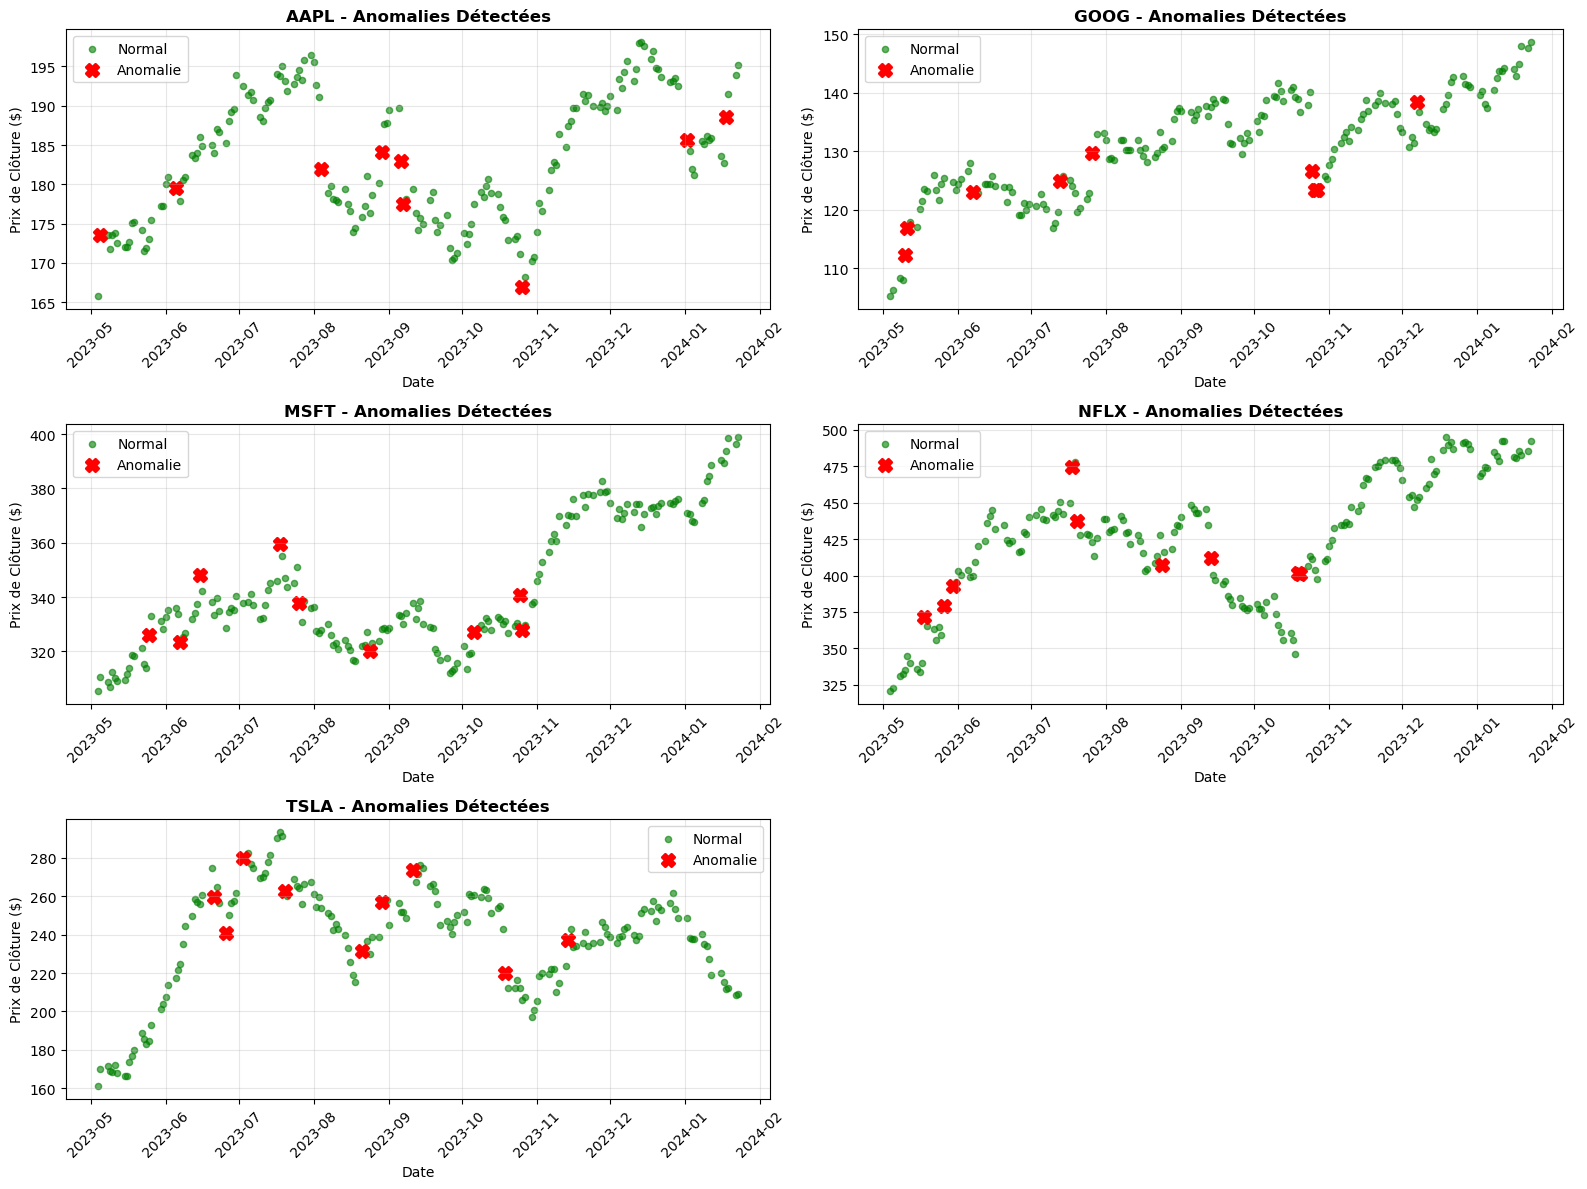

In [5]:
# Cell 5 - VISUALISATION DES ANOMALIES PAR ACTION
print("📊 VISUALISATION DES ANOMALIES DÉTECTÉES...")

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (ticker, data) in enumerate(results.items()):
    if i < len(axes):
        ax = axes[i]
        
        # Prix normaux
        normal_data = data[data['is_anomaly'] == 0]
        ax.scatter(normal_data['Date'], normal_data['Close'], 
                  c='green', alpha=0.6, label='Normal', s=20)
        
        # Anomalies
        anomaly_data = data[data['is_anomaly'] == 1]
        ax.scatter(anomaly_data['Date'], anomaly_data['Close'], 
                  c='red', alpha=1.0, label='Anomalie', s=80, marker='X', linewidth=2)
        
        ax.set_title(f'{ticker} - Anomalies Détectées', fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Prix de Clôture ($)')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

# Cacher le dernier subplot s'il est vide
if len(results) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

In [6]:
# Cell 7 - SAUVEGARDE DES RÉSULTATS POUR AZURE ML
print("💾 SAUVEGARDE DES RÉSULTATS POUR LE PROCHAIN ÉTAPE AZURE...")

# DataFrame final avec toutes les prédictions
final_results = pd.concat(results.values(), ignore_index=True)

# Features importantes pour Azure ML
output_columns = ['Ticker', 'Date', 'Close', 'Volume', 'daily_return', 
                  'volume_zscore', 'anomaly_score', 'is_anomaly']

final_results[output_columns].to_csv('anomaly_detection_results.csv', index=False)
summary_df.to_csv('anomaly_summary_by_ticker.csv', index=False)

print("✅ RÉSULTATS SAUVEGARDÉS!")
print("📁 Fichiers créés:")
print("   - anomaly_detection_results.csv (détails par jour)")
print("   - anomaly_summary_by_ticker.csv (résumé par action)")

print(f"\n🎯 PROCHAIN ÉTAPE: Déploiement Azure ML avec {len(final_results)} prédictions!")

💾 SAUVEGARDE DES RÉSULTATS POUR LE PROCHAIN ÉTAPE AZURE...
✅ RÉSULTATS SAUVEGARDÉS!
📁 Fichiers créés:
   - anomaly_detection_results.csv (détails par jour)
   - anomaly_summary_by_ticker.csv (résumé par action)

🎯 PROCHAIN ÉTAPE: Déploiement Azure ML avec 905 prédictions!
